In [1]:
import os
import tempfile
import shutil
from typing import List
from cog import BasePredictor, Path, Input, BaseModel

from openpsg.utils.utils import show_result
from mmdet.apis import init_detector, inference_detector
from mmcv import Config
import mmcv
from mmdet.datasets.coco_panoptic import INSTANCE_OFFSET
from detectron2.utils.colormap import colormap
from detectron2.utils.visualizer import VisImage, Visualizer
from mmdet.datasets import build_dataloader, replace_ImageToTensor
from mmdet.datasets.dataset_wrappers import (ClassBalancedDataset, ConcatDataset, RepeatDataset)
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint, wrap_fp16_model)
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmdet.apis import multi_gpu_test, single_gpu_test
from mmcv.cnn import fuse_conv_bn
from openpsg.datasets import build_dataset
from mmdet.models import build_detector

import torchvision
from matplotlib import pyplot as plt
import torch
import numpy as np
import random
from panopticapi.utils import rgb2id
import PIL
import cv2
import pandas as pd
from tqdm import tqdm
from collections import Counter
import nltk
from nltk.corpus import wordnet as wn

from tools.dataset import VOCDataset
from torch.utils.data import DataLoader

In [2]:
class ModelOutput(BaseModel):
    image: Path
    
device = torch.device('cuda:0')
model_ckt = "./work_dirs/checkpoints/epoch_60.pth"
cfg = Config.fromfile("configs/psgtr/psgtr_r50_psg.py")
model = init_detector(cfg, model_ckt, device="cpu").cuda(device)

load checkpoint from local path: ./work_dirs/checkpoints/epoch_60.pth


## coco data test

In [ ]:
import argparse

dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(dataset,
                                samples_per_gpu=1,
                                workers_per_gpu=cfg.data.workers_per_gpu,
                                dist=False,
                                shuffle=False)
args = argparse.Namespace(cfg_options=None, checkpoint='work_dirs/checkpoints/VCTree_epoch_12.pth', config='configs/vctree/panoptic_fpn_r50_fpn_1x_sgdet_psg.py', dataset_type_coco_root='../dataset/coco', eval=['sgdet'], eval_options=None, format_only=False, fuse_conv_bn=False, gpu_collect=False, launcher='none', local_rank=0, options=None, out=None, show=False, show_dir=None, show_score_thr=0.3, submit=False, tmpdir=None, work_dir='work_dirs/checkpoints/')
cfg = Config.fromfile(args.config)

In [ ]:
# build the model and load checkpoint
cfg.model.train_cfg = None
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
fp16_cfg = cfg.get('fp16', None)
if fp16_cfg is not None:
    wrap_fp16_model(model)
checkpoint = load_checkpoint(model, args.checkpoint, map_location='cpu')
if args.fuse_conv_bn:
    model = fuse_conv_bn(model)
# old versions did not save class info in checkpoints, this walkaround is
# for backward compatibility
if 'CLASSES' in checkpoint.get('meta', {}):
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    model.CLASSES = dataset.CLASSES
# NOTE:
if hasattr(dataset, 'PREDICATES'):
    model.PREDICATES = dataset.PREDICATES

In [ ]:
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader, args.show, args.show_dir,
                        args.show_score_thr)
rank, _ = get_dist_info()
if rank == 0:
    if args.out:
        print(f'\nwriting results to {args.out}')
        mmcv.dump(outputs, args.out)
    kwargs = {} if args.eval_options is None else args.eval_options
    if args.format_only:
        dataset.format_results(outputs, **kwargs)
    if args.eval:
        eval_kwargs = cfg.get('evaluation', {}).copy()
        # hard-code way to remove EvalHook args
        for key in [
                'interval', 'tmpdir', 'start', 'gpu_collect', 'save_best',
                'rule', 'dynamic_intervals'
        ]:
            eval_kwargs.pop(key, None)
        eval_kwargs.update(dict(metric=args.eval, **kwargs))
        metric = dataset.evaluate(outputs, **eval_kwargs)
        print(metric)
        metric_dict = dict(config=args.config, metric=metric)
        # if args.work_dir is not None and rank == 0:
        #     mmcv.dump(metric_dict, json_file)

## voc data test

In [18]:
nltk.download('wordnet')
nltk.download('omw-1.4')

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
             'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
voc_pair_coco = {}
voc_pair_coco_idx = {}
for word in model.CLASSES:
    temp = []
    for simword in wn.synsets(word):
        d = [i for i in voc_classes if i in simword.lemma_names()]
        temp += d
    if word == 'pottedplant':
        temp += ['potted plant']
    elif word == 'diningtable':
        temp += ['dining table']
    elif word == 'tvmonitor':
        temp += ['tv']

    if len(temp) == 0:
        continue
    else:
        temp = list(set(temp))
        voc_pair_coco[word] = temp
        voc_pair_coco_idx[word] = [voc_classes.index(i) for i in temp]

[nltk_data] Downloading package wordnet to /home/mini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/mini/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
img_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.PILToTensor(),
])
voc_dataset = VOCDataset(year='2007', split='test', root='../dataset/VOCdevkit', img_transform=img_transforms)
voc_data_loader = DataLoader(voc_dataset, shuffle=False, batch_size=1)

In [7]:
# Importing the get_result function from the tools.image_test module
from tools.image_test import get_result

# Setting the number of relations to 10
num_rel = 10

# Creating an empty list to store the output
output = []

# Looping through the data loader and getting each batch
for batch in tqdm(voc_data_loader):

    # Getting the original image from the batch and converting it to a numpy array
    img = batch['original_imgs']
    img = img.squeeze().numpy()

    # Running inference on the model to get the detection results
    result = inference_detector(model, img)

    # Getting the visualization image, labels, and relations using the get_result function
    viz_img, labels, relations = get_result(
        model,
        img,
        result,
        is_one_stage=True,
        num_rel=num_rel
    )

    # Appending the visualization image, labels, and relations to the output list
    output.append(
        {'viz_image': viz_img, 'labels': labels, 'relations': relations})


100%|██████████| 4952/4952 [35:22<00:00,  2.33it/s]


In [68]:
def check_overlap(label_idx, gt_idx):
    for idx in label_idx:
        if idx in gt_idx:
            return True
    return False

# Check if all elements in gt_idx are included in label_idx.
def check_inclusion(label_idx, gt_idx):
    # Convert both lists to sets for easy comparison.
    label_set = set(label_idx)
    gt_set = set(gt_idx)
    # Check if gt_set is a subset of label_set.
    if gt_set.issubset(label_set):
        return True
    else:
        return False

true_count, total_count, true_count_all = 0, 0, 0
for idx, i in tqdm(enumerate(output)):
    label_idx = list(set([voc_pair_coco_idx[word][0] for word in i['labels'] if word in voc_pair_coco_idx.keys()]))
    gt_idx = list(voc_dataset[idx]['gt'])
    count = check_overlap(label_idx, gt_idx)
    count2 = check_inclusion(label_idx, gt_idx)
    if count:
        true_count += 1
    if count2:
        true_count_all += 1
    total_count += 1
print(true_count, true_count_all, total_count, true_count/total_count, true_count_all/total_count)

4952it [00:28, 175.76it/s]

4494 3716 4952 0.9075121163166397 0.7504038772213247


dog attached to person
person holding dog
person wearing tie


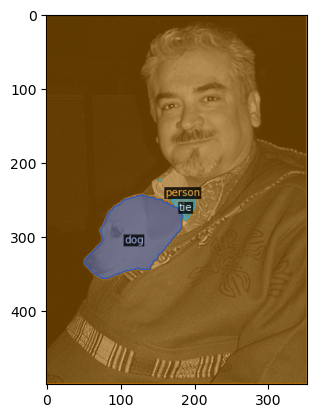

In [7]:
# sample inference
num_rel = 10
for batch in voc_data_loader:
    img = batch['original_imgs']
    img = img.squeeze().numpy()
    result = inference_detector(model, img)
    show_result(
        img,
        result,
        is_one_stage=True,
        num_rel=num_rel,
        show=True,
        show_rel = True,
    )
    break